In [6]:
%load_ext autoreload

import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from quil_utils import *
from pyquil.quil import Pragma, Program
from pyquil.api import get_qc,QVM
from pyquil.gates import *
from quil_utils import Compiled_Circuit
from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter,Gate_number
from IonQCompiler import IonQCompiler


import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
@circuit.subroutine(register=True)
def GHZ (n_qubits):
    """
    Creates a GHZ circuit with n_qubits
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    """
    out = Circuit().h([0])
    for i in range(n_qubits-1):
        out.cnot(0,i+1)

    return out
        

In [11]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
rigetti.is_available
#rigetti = LocalSimulator()
# ion_q = LocalSimulator()

False

In [12]:
shots = 1000
#set_n_qubits = range(3,10)
n_qubits_list = [2,4,6,8,10,11]

print(n_qubits_list)

[2, 4, 6, 8, 10]


In [14]:
id_dict = {}
rigetti_tasks = []
for n_qubits in n_qubits_list:
    id_dict[str(n_qubits)] = {}
    
    circ = GHZ (n_qubits)
    #print(circ)
    rigetti_task = rigetti.run(circ,shots=shots)
    rigetti_tasks.append(rigetti_task)
    
    id_dict[str(n_qubits)] = {'rigetti' : {'id' : rigetti_task.id,'BenchType':'GHZ','n_shots':shots,'n_qubits':n_qubits}}

In [15]:
with open('GHZ_rigetti.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [16]:
rigetti_ids = [task.id for task in rigetti_tasks]

In [17]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]

In [75]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
print(status_rigetti)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [76]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]

In [77]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_rigetti[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
    
#     measure.append({
#             'qubit_n' : qubit_number,
#            'value': '0',
#             'counts' : zeros})
#     measure.append({'H_len' : H_len,
#             'qubit_n' : qubit_number,
#            'value': '1','counts':ones})
measure_rigetti = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_rigetti

{'qubit_n': [2, 4, 6, 8, 10],
 'all_zeros': array([0.414, 0.255, 0.162, 0.012, 0.003]),
 'all_ones': array([0.436, 0.086, 0.025, 0.017, 0.   ]),
 'other': array([0.15 , 0.659, 0.813, 0.971, 0.997])}

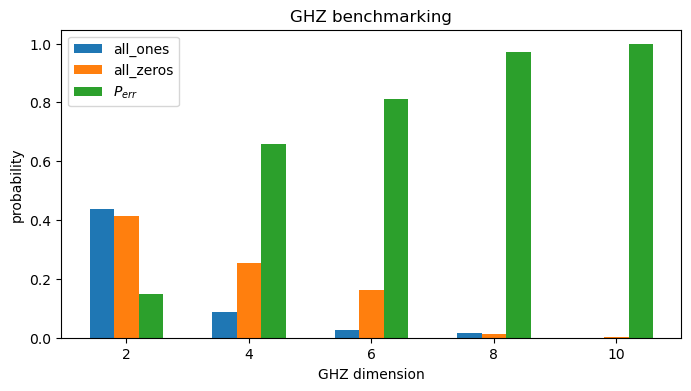

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_rigetti['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_rigetti['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

# IonQ compensated
Le simulazioni di Ionq sono anch'esse basate su GHZ ma aggiungendo randomicamente delle porte a singolo/due gates per mettere in luce che il suo vantaggio su Rigetti non dipende solamente da una minor overhead di compilazione

In [70]:
ion_q_compiler = IonQCompiler()

In [71]:
compiled_circuits_ion_q = [ion_q_compiler.compile(GHZ(n_qubits)) for n_qubits in n_qubits_list]
N_gates_ion_q = [len(ion_q_compiler.compile(GHZ(n_qubits)).instructions) for n_qubits in n_qubits_list]

In [101]:
compiled_circuits_rigetti = [task.get_compiled_circuit() for task in rigetti_task_scanners]

braket_circs_rigetti = [transpile_quil_to_braket(quil_circ)[0] for quil_circ in compiled_circuits_rigetti]
braket_circs_ion_q = compiled_circuits_ion_q

rigetti_gate_number_class = [Gate_number(circ) for circ in braket_circs_rigetti]
ionq_gate_number_class = [Gate_number(circ) for circ in braket_circs_ion_q]

In [115]:
def compensated_ghz_ion_q(n_qubits,rigetti_qubit_number_class):
    ion_q_compiler = IonQCompiler()
    GHZ_standard = GHZ (n_qubits)
    GHZ_std_compiled = ion_q_compiler.compile(GHZ_standard)
    rigetti_entangling_gates = rigetti_qubit_number_class.entangling_gates
    rigetti_one_qubit_gates = rigetti_qubit_number_class.one_qubit
    ion_q_entangling_gates = Gate_number(GHZ_std_compiled).entangling_gates
    ion_q_one_qubit_gates = Gate_number(GHZ_std_compiled).one_qubit
    
    
    GHZ_compensated = GHZ_std_compiled
    n_entangled_to_compensate = int(np.ceil(.5*(rigetti_entangling_gates-ion_q_entangling_gates)))
    n_single_to_compensate = int(np.ceil(.5*(rigetti_one_qubit_gates-ion_q_one_qubit_gates)))
    
    for _ in range(n_entangled_to_compensate):
        theta1,theta2 = np.random.random(2)*2*np.pi
        q1= np.random.randint(n_qubits)
        q2 = q1
        while q2==q1:
            q2 = np.random.randint(n_qubits)
        GHZ_compensated.ms(q1,q2,theta1,theta2).ms(q1,q2,theta1,theta2+np.pi)
        
    for _ in range (n_single_to_compensate):
        coin = np.random.random()
        theta = np.random.random()*2*np.pi
        q = np.random.randint(n_qubits)
        if coin >.5:     
            GHZ_compensated.gpi(q,theta).gpi(q,theta)
        else:
            GHZ_compensated.gpi2(q,theta).gpi2(q,theta+np.pi)

    return Circuit().add_verbatim_box(GHZ_compensated)
        

In [129]:
id_dict = {}
ionq_tasks = []
for i,n_qubits in enumerate(n_qubits_list):
    id_dict[str(n_qubits)] = {}
    
    
    circ = compensated_ghz_ion_q(n_qubits,rigetti_gate_number_class[i])
    #print(circ)

    ionq_task = ion_q.run(circ,shots=shots)
    ionq_tasks.append(ionq_task)
    id_dict[str(n_qubits)] = {'ionq' : {'id' : ionq_task.id,'BenchType':'GHZ','n_shots':shots,'n_qubits':n_qubits}}

In [130]:
with open('GHZ_ion_q.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [133]:
ion_q_ids = [task.id for task in ionq_tasks]

In [134]:
ion_q_task_scanners = [BraketTaskScanner(qtask=task) for task in ionq_tasks]

In [136]:
status_ion_q = [task.get_status() for task in ion_q_task_scanners]
print(status_ion_q)

['QUEUED', 'QUEUED', 'QUEUED', 'QUEUED', 'QUEUED']


In [76]:
results_ion_q = [qtask.get_results() for qtask in ion_q_task_scanners]

In [77]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_rigetti[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_rigetti = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_rigetti

{'qubit_n': [2, 4, 6, 8, 10],
 'all_zeros': array([0.414, 0.255, 0.162, 0.012, 0.003]),
 'all_ones': array([0.436, 0.086, 0.025, 0.017, 0.   ]),
 'other': array([0.15 , 0.659, 0.813, 0.971, 0.997])}

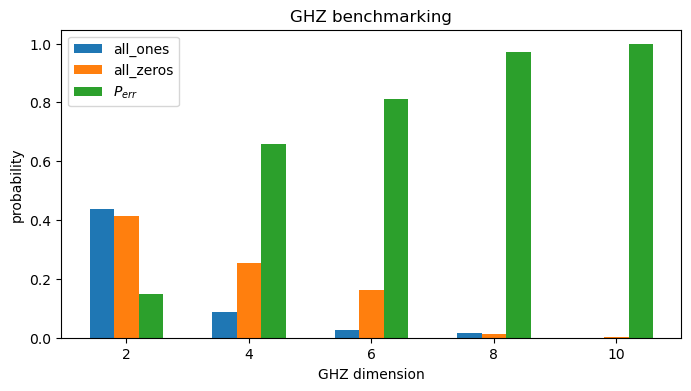

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_rigetti['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_rigetti['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

### testing that all Ionq physical gates Adjoint matrix

1. Gpi(theta)

In [24]:
theta = np.random.random()*2*np.pi
Circuit().gpi(0,theta).gpi(0,theta).as_unitary()

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

2. Gpi2(theta)

In [62]:
theta = np.random.random()*2*np.pi
Circuit().gpi2(0,theta).gpi2(0,np.pi+theta).as_unitary()

array([[ 1.00000000e+00+3.33066907e-16j,  2.22044605e-16-2.22044605e-16j],
       [-2.22044605e-16-2.22044605e-16j,  1.00000000e+00-3.33066907e-16j]])

3. Ms(t1,t2)

In [68]:
theta1,theta2 = np.random.random(2)*2*np.pi
Circuit().ms(0,1,theta1,theta2).ms(0,1,theta1,theta2+np.pi).as_unitary().round(3)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j,  1.-0.j]])

In [67]:
np.matrix(Circuit().ms(0,1,theta1,theta2).as_unitary()).H.round(3)

matrix([[ 0.707-0.j   ,  0.   -0.j   ,  0.   -0.j   , -0.652+0.273j],
        [ 0.   -0.j   ,  0.707-0.j   ,  0.681-0.19j ,  0.   -0.j   ],
        [ 0.   -0.j   , -0.681-0.19j ,  0.707-0.j   ,  0.   -0.j   ],
        [ 0.652+0.273j,  0.   -0.j   ,  0.   -0.j   ,  0.707-0.j   ]])